In [1]:
import os
import yaml
import fsspec
import itertools

import datamol as dm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mood.rct import get_experimental_configurations
from mood.dataset import MOOD_DATASETS, MOOD_REGR_DATASETS
from mood.metrics import Metric
from mood.utils import get_outlier_bounds
from mood.model import MOOD_ALGORITHMS
from mood.representations import MOOD_REPRESENTATIONS
from mood.splitter import MOOD_SPLITTERS
from mood.criteria import MOOD_CRITERIA

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Simple custom loader to ignore Python tags

class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

# Load the data

In [3]:
SUBDIR = "20230225"
BASE_PATH = "gs://experiments-output/mood-v2/results/YAML/RCT/"
N_RCT_TRIALS = 250

In [4]:
def get_result_paths_for_dataset(dataset):
    pattern = dm.fs.join(BASE_PATH, SUBDIR, f"*{dataset}*.yaml")
    paths = dm.fs.glob(pattern)
    return paths


def find_missing(dataset, n: int = N_RCT_TRIALS):
    
    paths = get_result_paths_for_dataset(dataset)
    all_configs = get_experimental_configurations(dataset)[:n]
    indices = list(range(n))
    
    for path in paths: 
        
        path = dm.fs.get_basename(path)
        path = os.path.splitext(path)[0]
        
        config = path.split("_")[4:]
        config[-1] = int(config[-1])
        config = tuple(config)
        
        indices.remove(all_configs.index(config))
        
    return indices
        

for dataset in MOOD_DATASETS:
    missing = find_missing(dataset)
    print(f"Missing {len(missing)}/{N_RCT_TRIALS} of results for {dataset}: {missing}")

Missing 28/250 of results for DILI: [18, 52, 59, 60, 70, 108, 111, 123, 126, 134, 140, 142, 144, 146, 161, 170, 184, 185, 186, 187, 189, 202, 203, 205, 211, 217, 220, 230]
Missing 47/250 of results for HIA: [7, 15, 16, 18, 21, 22, 23, 29, 38, 48, 54, 59, 60, 62, 74, 78, 89, 95, 97, 103, 104, 106, 115, 116, 120, 122, 133, 135, 136, 151, 154, 159, 162, 166, 172, 176, 179, 196, 203, 206, 213, 215, 225, 227, 237, 241, 244]
Missing 55/250 of results for hERG: [0, 6, 8, 9, 15, 16, 20, 26, 35, 37, 40, 42, 43, 44, 45, 48, 67, 68, 72, 81, 91, 98, 100, 104, 105, 109, 111, 115, 118, 121, 127, 131, 146, 147, 149, 150, 153, 154, 164, 167, 170, 188, 196, 200, 216, 218, 224, 226, 229, 234, 235, 238, 245, 246, 247]
Missing 41/250 of results for HalfLife: [6, 22, 57, 63, 64, 65, 72, 73, 78, 80, 81, 84, 87, 88, 92, 96, 103, 110, 124, 134, 135, 148, 163, 165, 172, 176, 179, 199, 205, 206, 207, 208, 209, 215, 220, 226, 230, 237, 240, 244, 246]
Missing 34/250 of results for Caco-2: [11, 15, 17, 43, 48, 56,

In [5]:
def load_results(path):
    with fsspec.open(path, "r") as fd:
        data = yaml.load(fd, Loader=SafeLoaderIgnoreUnknown)
        data.pop("hparams")
    
    data.pop("criterion_final")

    # NOTE: Due to a bug, for some early workflows the seed in the YAML was faulty. 
    # Luckily, we can still extract the right seed from the filename
    if "trial_seed" not in data:
        data["trial_seed"] = data["seed"]
        data["seed"] = int(path[-6])
    
    # Add some additional information
    df = pd.DataFrame(data, index=[0])
    
    metric_cal = Metric.get_default_calibration_metric(data["dataset"])
    metric_prf = Metric.get_default_performance_metric(data["dataset"])
    
    df["metric_calibration"] = metric_cal.name
    df["metric_performance"] = metric_prf.name
    df["minimize_calibration"] = metric_cal.mode == "min"
    df["minimize_performance"] = metric_prf.mode == "min"
    
    df.columns = [col.replace(f"{metric_prf.name}_", "") for col in df.columns]
    df.columns = [col.replace(f"{metric_cal.name}_", "") for col in df.columns]
    return df


paths = [p for dataset in MOOD_DATASETS for p in get_result_paths_for_dataset(dataset)]
df_original = pd.concat(dm.utils.parallelized(load_results, paths, progress=True), ignore_index=True)
df_original.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2066/2066 [00:27<00:00, 74.57it/s]


,algorithm,criterion,dataset,representation,seed,test_calibration_0,test_calibration_1,test_calibration_2,test_calibration_final,test_performance_0,...,val_extra_pearson_2,val_extra_pearson_final,val_extra_r2_0,val_extra_r2_1,val_extra_r2_2,val_extra_r2_final,val_extra_spearman_0,val_extra_spearman_1,val_extra_spearman_2,val_extra_spearman_final
0,CORAL,Performance,DILI,ChemBERTa,2,0.189520,0.221250,0.260150,0.219933,0.785714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CORAL,Distance Weighted Performance,DILI,ChemBERTa,1,0.492302,0.500334,0.480945,0.471713,0.770499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CORAL,Calibration,DILI,Desc2D,6,0.066264,0.173510,0.173072,0.066264,0.403619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CORAL,Distance Weighted Performance,DILI,Desc2D,3,0.518266,0.498849,0.476540,0.502780,0.863103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CORAL,Distance Weighted Performance,DILI,Desc2D,1,0.283731,0.345310,0.282581,0.312234,0.864431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_original.groupby("dataset")[["test_performance_final", "test_calibration_final"]].describe()

test_performance_final                                       \
                               count         mean           std       min   
dataset                                                                     
BBB                            181.0     0.669064      0.150214  0.257759   
CYP2C9                         143.0     0.726375      0.112145  0.265066   
Caco-2                         216.0    68.702568    901.881859  0.439549   
Clearance                      227.0  3034.354672  45437.841269  0.542546   
DILI                           222.0     0.675355      0.138325  0.180861   
HIA                            203.0     0.677219      0.202086  0.058266   
HalfLife                       209.0   486.722498   6820.211292  0.101352   
Lipophilicity                   85.0    87.869083    801.320778  0.439891   
PPBR                           204.0    93.108564    900.213378  0.479385   
Pgp                            181.0     0.758839      0.162743  0.125926   
hERG                           195.0     0.652588      0.150390  0.186499   

                                                            \
                    25%       50%       75%            max   
dataset                                                      
BBB            0.574464  0.685787  0.780067       0.933309   
CYP2C9         0.666330  0.751351  0.794995       0.878084   
Caco-2         0.613205  0.739018  0.829815   13232.986328   
Clearance      0.739808  0.825732  0.882107  684603.875000   
DILI           0.585685  0.702865  0.773692       0.899483   
HIA            0.507649  0.676278  0.866351       0.993902   
HalfLife       0.210723  0.301202  0.437046   98595.601562   
Lipophilicity  0.670447  0.750615  0.812073    7388.756348   
PPBR           0.626873  0.709208  0.865059   11986.520508   
Pgp            0.697947  0.823911  0.866974       0.964099   
hERG           0.565442  0.662439  0.767459       0.891884   

              test_calibration_final                                          \
                               count      mean       std       min       25%   
dataset                                                                        
BBB                            181.0  0.391185  0.244340  0.003228  0.205664   
CYP2C9                         143.0  0.212274  0.118341  0.000000  0.140186   
Caco-2                         213.0  0.113899  0.318206 -1.000000 -0.071037   
Clearance                      226.0  0.143568  0.362911 -1.000000 -0.044959   
DILI                           221.0  0.290179  0.118566  0.000000  0.241275   
HIA                            202.0  0.442210  0.345696  0.001822  0.130768   
HalfLife                       207.0  0.268901  0.385983 -1.000000 -0.014936   
Lipophilicity                   85.0  0.124071  0.296483 -1.000000  0.021943   
PPBR                           200.0  0.177486  0.330174 -1.000000 -0.022934   
Pgp                            181.0  0.321487  0.134412  0.000000  0.241649   
hERG                           194.0  0.370399  0.220941  0.000000  0.190072   

                                             
                    50%       75%       max  
dataset                                      
BBB            0.301967  0.626574  0.978499  
CYP2C9         0.201573  0.286386  0.518341  
Caco-2         0.051167  0.186468  1.000000  
Clearance      0.084464  0.243555  1.000000  
DILI           0.270730  0.329320  0.994068  
HIA            0.281197  0.811863  0.985085  
HalfLife       0.086059  0.593186  1.000000  
Lipophilicity  0.099316  0.164195  1.000000  
PPBR           0.112475  0.301314  1.000000  
Pgp            0.288943  0.391236  0.985813  
hERG           0.288428  0.549055  0.994660

In [7]:
df_original.groupby("dataset")[["val_performance_final", "val_calibration_final"]].describe()

val_performance_final                                     \
                              count        mean          std       min   
dataset                                                                  
BBB                           181.0    0.719506     0.171497  0.199826   
CYP2C9                        143.0    0.761267     0.110757  0.487367   
Caco-2                        216.0   26.626125   329.782899  0.327273   
Clearance                     227.0  219.938216  3017.643565  0.498429   
DILI                          222.0    0.732000     0.161227  0.227582   
HIA                           203.0    0.746483     0.201286  0.234300   
HalfLife                      209.0   10.113812    80.433971  0.091070   
Lipophilicity                  85.0   91.384946   834.317072  0.446789   
PPBR                          204.0   78.679986   797.771178  0.362644   
Pgp                           181.0    0.762140     0.201973  0.000000   
hERG                          195.0    0.715193     0.179640  0.200990   

                                                           \
                    25%       50%       75%           max   
dataset                                                     
BBB            0.601010  0.756182  0.867003      0.975450   
CYP2C9         0.705550  0.789271  0.850071      0.899683   
Caco-2         0.623993  0.738444  0.850937   4821.282715   
Clearance      0.683630  0.766100  0.826951  45395.898438   
DILI           0.611520  0.768607  0.861653      0.977376   
HIA            0.571429  0.784912  0.931357      1.000000   
HalfLife       0.171684  0.217736  0.385360    964.740295   
Lipophilicity  0.626361  0.714786  0.784245   7692.904297   
PPBR           0.568624  0.653168  0.737816  10275.051758   
Pgp            0.672301  0.838393  0.916048      0.990356   
hERG           0.572082  0.777037  0.849703      0.980969   

              val_calibration_final                                          \
                              count      mean       std       min       25%   
dataset                                                                       
BBB                           181.0  0.408113  0.259951  0.000654  0.192083   
CYP2C9                        143.0  0.233129  0.136285  0.000000  0.156864   
Caco-2                        215.0  0.204193  0.300896 -0.342138  0.002019   
Clearance                     224.0  0.203954  0.349422 -1.000000 -0.019806   
DILI                          222.0  0.290181  0.125263  0.000000  0.237809   
HIA                           203.0  0.434194  0.339516  0.003046  0.127752   
HalfLife                      204.0  0.302960  0.404411 -1.000000 -0.005888   
Lipophilicity                  84.0  0.150845  0.260012 -1.000000  0.052549   
PPBR                          203.0  0.214000  0.358091 -1.000000 -0.021768   
Pgp                           181.0  0.322159  0.135375  0.000000  0.239347   
hERG                          195.0  0.349180  0.191598  0.000000  0.218351   

                                             
                    50%       75%       max  
dataset                                      
BBB            0.284324  0.663735  0.981715  
CYP2C9         0.219566  0.314433  0.624925  
Caco-2         0.116789  0.297508  1.000000  
Clearance      0.100890  0.313449  1.000000  
DILI           0.260547  0.341191  0.999647  
HIA            0.281768  0.801172  0.973865  
HalfLife       0.131466  0.687818  1.000000  
Lipophilicity  0.124450  0.194454  1.000000  
PPBR           0.139371  0.346336  1.000000  
Pgp            0.303016  0.399858  0.724454  
hERG           0.292529  0.505811  0.813051

# Grouping by dataset class

In [8]:
mapping = {
    "RF": "IID",
    "GP": "IID",
    "MLP": "IID",
    "CORAL": "DA", 
    "DANN": "DA",
    "Mixup": "DA",
    "IB-ERM": "DG",
    "VREx": "DG",
    "MTL": "DG",
}
df_original["algorithm_class"] = df_original["algorithm"].apply(mapping.get)

# Comparing options

In [9]:
def clip_outliers(df, col):
    dfs = []
    for name, group in df.groupby("dataset"):
        lower, upper = get_outlier_bounds(group[col], factor=5.0)
        group[col] = group[col].clip(lower, upper)
        dfs.append(group)
    
    return pd.concat(dfs, ignore_index=True)


def diff_x_y(x, y, minimize):
    xv, yv = np.meshgrid(x, y, indexing='ij')    
    xv = xv.flatten()
    yv = yv.flatten()
    
    delta = xv - yv
    if minimize:
        return -delta
    else:
        return delta


def relative_diff_for_category(data, category, for_calibration: bool):
    diffs = pd.DataFrame()
    
    if for_calibration: 
        col = "test_calibration_final"
    else:
        col = "test_performance_final"

    data = clip_outliers(data, col)
    unique = data[category].unique()
    
    for ds_name, ds_data in data.groupby("dataset"):
        
        for x, y in itertools.combinations(unique, 2):
            x_data = ds_data[ds_data[category] == x][col].to_numpy()
            y_data = ds_data[ds_data[category] == y][col].to_numpy()
            
            if len(x_data) == 0 or len(y_data) == 0:
                continue
                        
            if for_calibration:
                minimize = ds_data["minimize_calibration"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            else:
                minimize = ds_data["minimize_performance"].unique()
                assert len(minimize) == 1
                minimize = minimize[0]
            
            delta1 = diff_x_y(x_data, y_data, minimize)
            delta2 = diff_x_y(y_data, x_data, minimize)

            i = len(diffs)
            df_1 = pd.DataFrame({"x": x, "y": y, "delta": delta1, "dataset": ds_name})
            df_2 = pd.DataFrame({"x": y, "y": x, "delta": delta2, "dataset": ds_name})
            diffs = pd.concat((diffs, df_1, df_2))
    
    diffs = diffs.reset_index(drop=True)
    return diffs

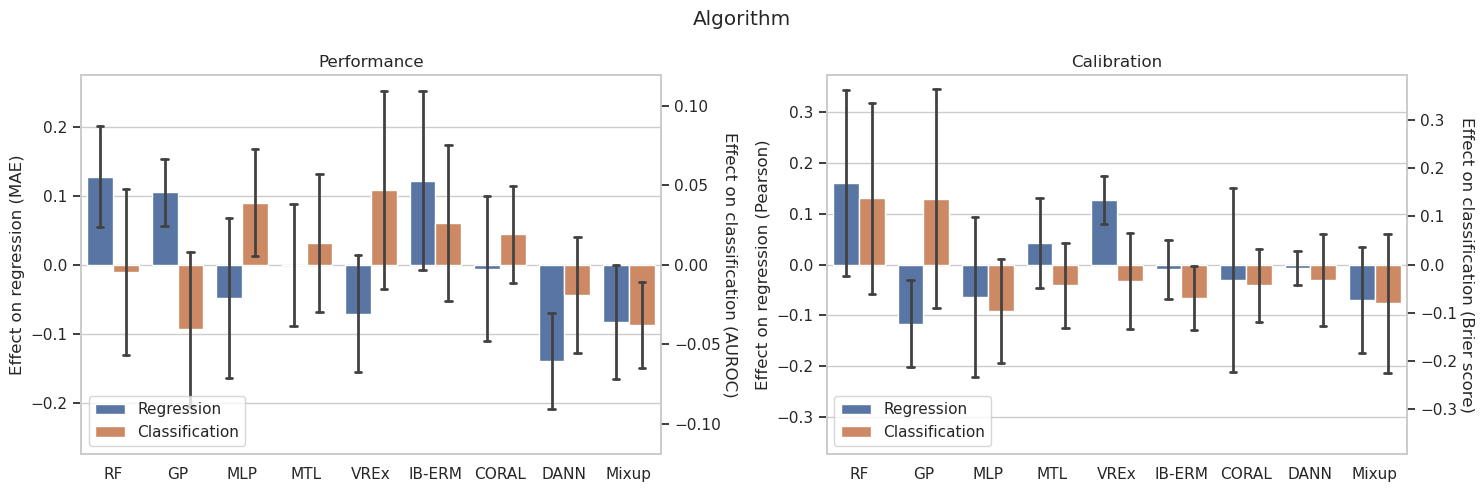

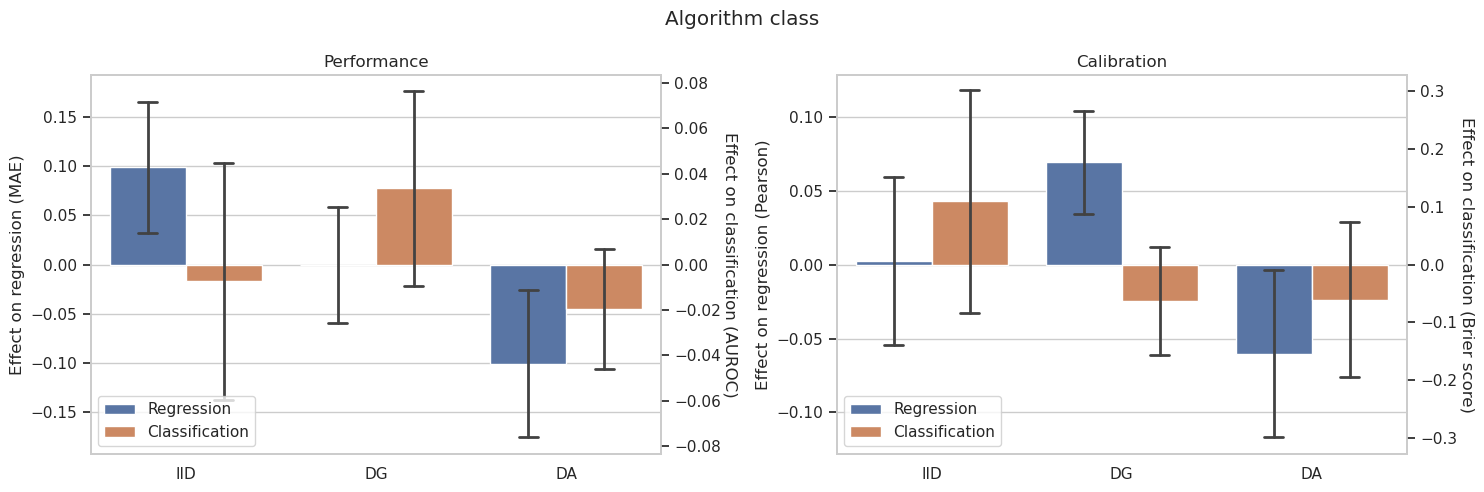

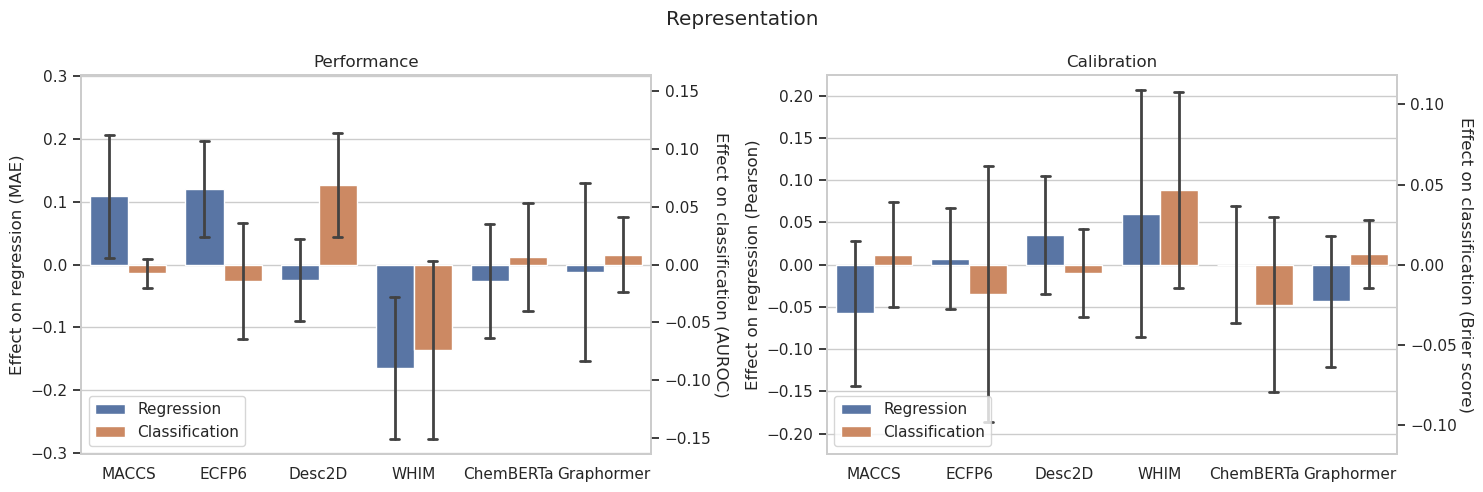

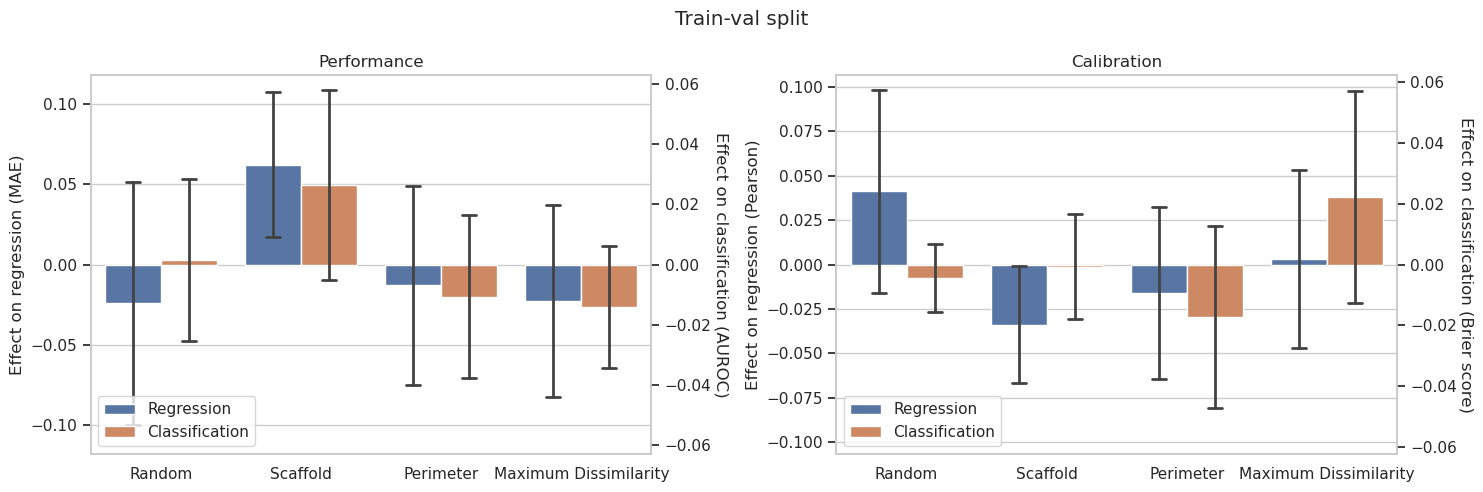

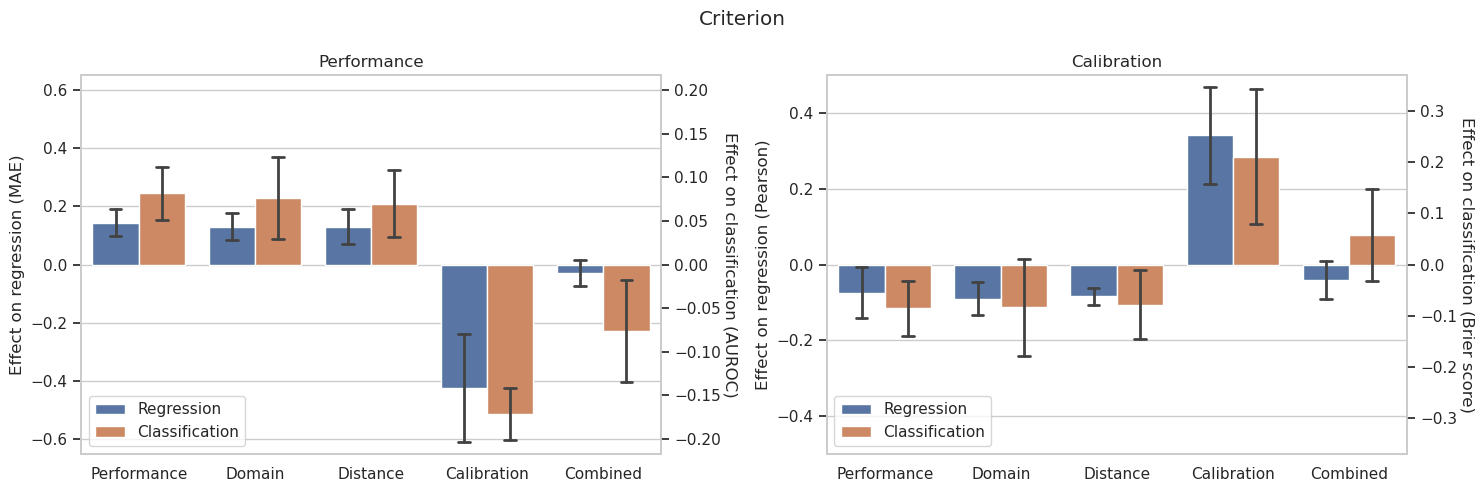

In [10]:
CAT_TO_RENAME = {
    "criterion": {
        "Domain Weighted Performance": "Domain",
        "Distance Weighted Performance": "Distance",
        "Calibration": "Calibration",
        "Performance": "Performance",
        "Calibration x Performance": "Combined"
    },
}


CAT_TO_ORDERING = {
    "algorithm": MOOD_ALGORITHMS,
    "representation": MOOD_REPRESENTATIONS,
    "criterion": MOOD_CRITERIA,
    "train_val_split": MOOD_SPLITTERS,
    "algorithm_class": ["IID", "DG", "DA"],
}

CAT_TO_TITLE = {
    "algorithm": "Algorithm",
    "representation": "Representation",
    "criterion": "Criterion",
    "train_val_split": "Train-val split",
    "algorithm_class": "Algorithm class"
}


def plot_single(df, category, is_calibration, ax_regression, cmap, metrics):
    
    ax_classification = ax_regression.twinx()
    
    diffs = relative_diff_for_category(df, category, is_calibration)
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs["task_type"] =  diffs["dataset"].apply(lambda x: "regression" if x in MOOD_REGR_DATASETS else "classification")
    
    for idx, (task_type, ax) in enumerate(zip(["regression", "classification"], [ax_regression, ax_classification])):
        
        data = diffs[diffs["task_type"] == task_type]
        sns.barplot(
            data=data, 
            x="x", 
            y="delta", 
            errorbar="sd", 
            capsize=0.1, 
            errwidth=2, 
            palette=cmap,
            ax=ax, 
            hue="task_type", 
            dodge=True,
            hue_order=["regression", "classification"], 
            order=CAT_TO_ORDERING[category]
        )
        
        low, high = ax.get_ylim()
        bound = max(abs(low), abs(high))
        ax.set_ylim(-bound, bound)
        ax.legend().remove()
        
    ax.set_title("Calibration" if is_calibration else "Performance")
    
    legend = ax_classification.legend(loc="lower left")
    legend.get_texts()[0].set_text("Regression")
    legend.get_texts()[1].set_text("Classification")
    
    ax_classification.grid(visible=False)
    ax_regression.set_xlabel("")
    
    rename = CAT_TO_RENAME.get(category, {})
    labels = ax_regression.get_xticklabels()
    labels = [rename.get(label.get_text(), label.get_text()) for label in labels]
    ax_regression.set_xticklabels(labels, fontsize=11)
    
    ax_classification.set_ylabel(f"Effect on classification ({metrics[1]})", rotation=270, labelpad=12)
    ax_regression.set_ylabel(f"Effect on regression ({metrics[0]})")


def plot(df):
    df = df.copy()
    
    sns.set_theme(style="whitegrid")
    cmap = sns.color_palette()
    
    for category in ["algorithm", "algorithm_class", "representation", "train_val_split", "criterion"]:
        
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
        for icol, is_calibration in enumerate([False, True]):
            
            if is_calibration:
                metrics = ("Pearson", "Brier score")
            else:
                metrics = ("MAE", "AUROC")
            
            plot_single(df, category, is_calibration, axs[icol], cmap=cmap, metrics=metrics)
        
        fig.suptitle(CAT_TO_TITLE[category])
        plt.tight_layout()

    
plot(df_original)

## Comparing tools

In [11]:
def get_tool_importance(df, is_calibration, is_regression):
    importances = {}
    
    mask = df["dataset"].isin(MOOD_REGR_DATASETS)
    if not is_regression:
        mask = ~mask
    df = df[mask]
    
    for idx, category in enumerate(["algorithm", "algorithm_class", "representation", "train_val_split", "criterion", "seed"]):
        diffs = relative_diff_for_category(df, category, is_calibration)
        diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
        diffs = diffs.groupby("x").mean()["delta"]

        importance = diffs.std()
        importances[category] = importance

    importances = {k: v / importances["seed"] for k, v in importances.items()}
    return importances

### Regression

In [12]:
# Performance
get_tool_importance(df_original, False, True)

{'algorithm': 1.7899183003670733,
 'algorithm_class': 1.8310611795598135,
 'representation': 1.9181530611058322,
 'train_val_split': 0.7592860311469176,
 'criterion': 4.450081948266319,
 'seed': 1.0}

In [13]:
# Calibration
get_tool_importance(df_original, True, True)

{'algorithm': 2.091654045920253,
 'algorithm_class': 1.4763952691403106,
 'representation': 1.024851479520108,
 'train_val_split': 0.7324430322384488,
 'criterion': 4.2395874900816075,
 'seed': 1.0}

### Classification

In [14]:
# Performance
get_tool_importance(df_original, False, False)

{'algorithm': 1.8122609961017744,
 'algorithm_class': 1.5705832837159812,
 'representation': 2.5841394792586505,
 'train_val_split': 1.0422136329947855,
 'criterion': 6.465695541812339,
 'seed': 1.0}

In [15]:
# Calibration
get_tool_importance(df_original, True, False)

{'algorithm': 3.4440665315027714,
 'algorithm_class': 3.8611851158213097,
 'representation': 0.9924019408596925,
 'train_val_split': 0.6432462105779626,
 'criterion': 5.105692460251897,
 'seed': 1.0}

# Recompute criteria importance without outlier

In [16]:
def get_criterion_importance(df, is_calibration, is_regression):
    importances = {}
    
    mask = df["dataset"].isin(MOOD_REGR_DATASETS)
    if not is_regression:
        mask = ~mask
    df = df[mask]
    
    diffs = relative_diff_for_category(df, "criterion", is_calibration)
    diffs = diffs[~diffs["x"].isin(["Calibration", "Calibration x Performance"])]
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs = diffs.groupby("x").mean()["delta"]
    importance_criterion = diffs.std()
    
    diffs = relative_diff_for_category(df, "seed", is_calibration)
    diffs = diffs.groupby(["x", "dataset"]).mean().reset_index()
    diffs = diffs.groupby("x").mean()["delta"]
    importance_seed = diffs.std()

    return importance_criterion / importance_seed

In [17]:
im1 = get_criterion_importance(df_original, True, True)
im2 = get_criterion_importance(df_original, True, False)
im3 = get_criterion_importance(df_original, False, True)
im4 = get_criterion_importance(df_original, False, False)
im1, im2, im3, im4

(0.18639645914771827,
 0.13232555948333613,
 0.14780528703846277,
 0.3416527913945441)

The End.